In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from matplotlib.ticker import MaxNLocator
import pickle
import dabench as dab
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Plot comparing runtimes and RMSE for baserun, 4D-Var and BP-4DVar

In [2]:
baserun_time_df = pd.read_csv('./out/pyqg_jax/pyqg_baserun_results_test_v1.csv')
var4d_df_3outer = pd.read_csv('./out/pyqg_jax/pyqg_4dvar_results_test_v2_sysdimxy_all_fullyear.csv')
bp_hessian_approx_3epochs = pd.read_csv('./out/pyqg_jax/pyqg_bp_results_test_v9_hessian_approx_3epoch.csv')
bp_hessian_exact_3epochs = pd.read_csv('./out/pyqg_jax/pyqg_bp_results_test_v8_hessian_exact_3epoch_noraytune_1_1.csv')

In [3]:
def apply_updates_filters(df):
    df['system_dim'] = 2*df['system_dim_xy']**2
    # Some csvs are from when we were also doing a run with system_dim_xy of 20
    # Remove those, not using anymore
    df= df.loc[df['system_dim_xy']!=20]
    return df.set_index('system_dim')

In [4]:
var4d_df_3outer = apply_updates_filters(var4d_df_3outer)
bp_hessian_approx_3epochs = apply_updates_filters(bp_hessian_approx_3epochs)
bp_hessian_exact_3epochs = apply_updates_filters(bp_hessian_exact_3epochs)
baserun_time_df = apply_updates_filters(baserun_time_df)

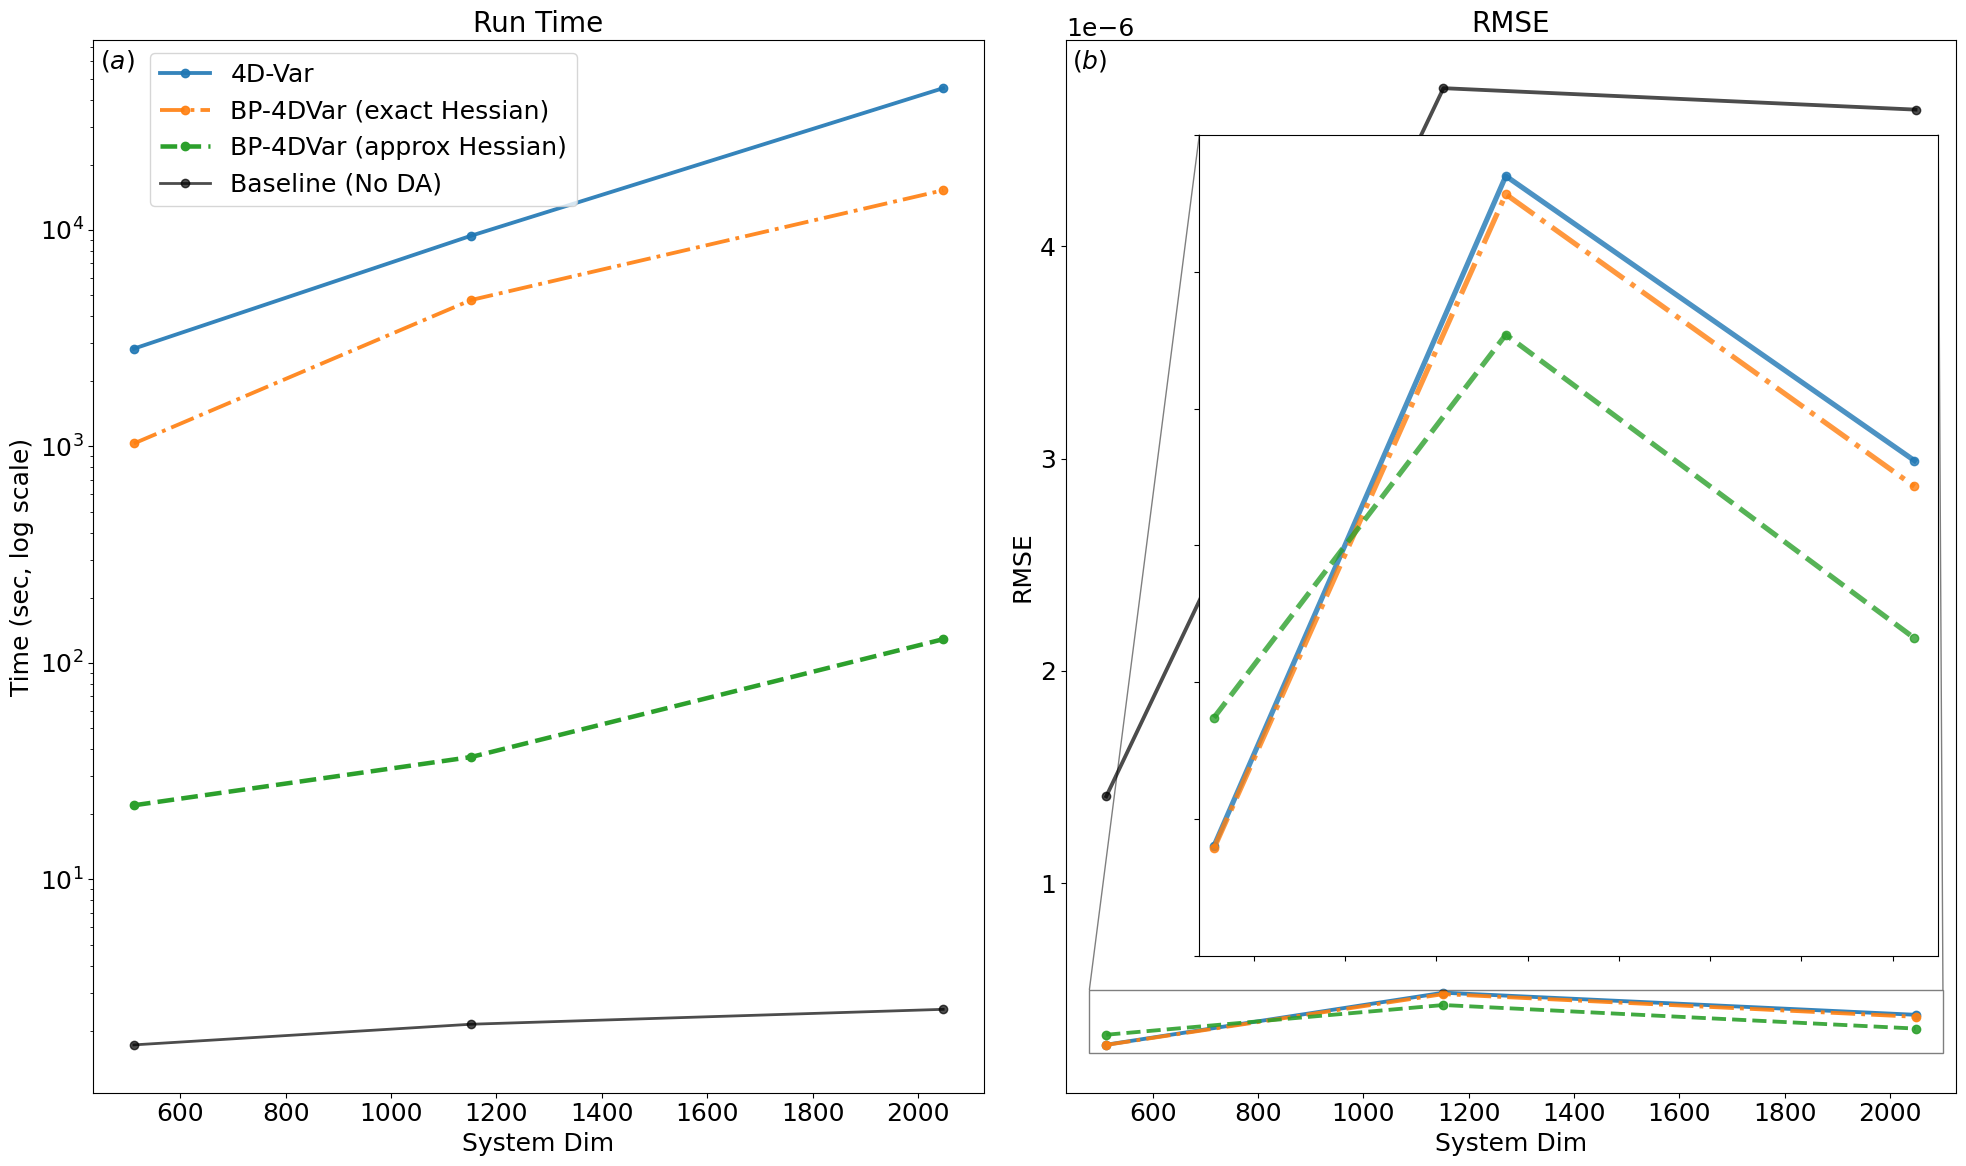

In [5]:
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 2, figsize = (20, 12))

# Plot times
var4d_df_3outer['da_time'].plot(ax=axs[0], style='.-', markersize=12, lw=2.75, alpha=0.9)
bp_hessian_exact_3epochs['da_time'].plot(ax=axs[0], style='.-.', markersize=12, lw=2.75, alpha=0.9)
bp_hessian_approx_3epochs['da_time'].plot(ax=axs[0], style='.--', markersize=12, lw=3.25, alpha=1.0)
baserun_time_df['da_time'].plot(ax=axs[0], style='.-', markersize=12, lw=2, alpha=0.7,color='black')

# Plot RMSEs
var4d_df_3outer['rmse'].plot(ax=axs[1], style='.-', markersize=12, lw=2.75, alpha=0.9)
bp_hessian_exact_3epochs['rmse'].plot(ax=axs[1], style='.-.', markersize=12, lw=2.75, alpha=0.9)
bp_hessian_approx_3epochs['rmse'].plot(ax=axs[1], style='.--', markersize=12, lw=2.75, alpha=0.9)
baserun_time_df['rmse'].plot(ax=axs[1], style='.-', markersize=12, lw=2.75, alpha=0.7,color='black')

# Basic labeling
axs[0].set_ylabel('Time (sec, log scale)')
axs[0].set_yscale('log')
axs[0].legend(labels=[
    '4D-Var',
    'BP-4DVar (exact Hessian)',
    'BP-4DVar (approx Hessian)',
    'Baseline (No DA)'
    ],
             loc='upper left', bbox_to_anchor=(0.05, 1.0))
axs[1].set_ylabel('RMSE')
axs[0].set_xlabel('System Dim')
axs[1].set_xlabel('System Dim')
axs[0].set_title('Run Time', size=20)
axs[1].set_title('RMSE', size=20)

axs[0].annotate(
        '$(a)$',
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.25, -0.3), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif')
axs[1].annotate(
        '$(b)$',
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.25, -0.3), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif')

# Creating inset
x1, x2, y1, y2 = 480, 2100, 2e-7, 0.5e-6  # Subregion of the original image
axins = axs[1].inset_axes(
    [0.15, 0.13, 0.83, 0.78],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
var4d_df_3outer['rmse'].plot(ax=axins, style='.-', markersize=12, lw=3.75, alpha=0.8)
bp_hessian_exact_3epochs['rmse'].plot(ax=axins, style='.-.', markersize=12, lw=3.75, alpha=0.8)
bp_hessian_approx_3epochs['rmse'].plot(ax=axins, style='.--', markersize=12, lw=3.75, alpha=0.8)
axins.set_xlabel('')

axs[1].indicate_inset_zoom(axins, edgecolor="black")

fig.tight_layout()

# Generate nature run and observations for timeseries figure

In [6]:
year_in_timesteps = 4380
spinup_size = 5*year_in_timesteps
valid_size = round(year_in_timesteps/4)
transient_size = 1*year_in_timesteps
test_size = 1*year_in_timesteps

In [7]:
system_dim_xy = 32
nr_steps = spinup_size + valid_size + transient_size + test_size
delta_t=7200
random_seed=system_dim_xy

In [8]:
nature_run = dab.data.PyQGJax(nx=system_dim_xy, ny=system_dim_xy, delta_t=delta_t, store_as_jax=True, random_seed=random_seed)

nature_run.generate(n_steps=nr_steps) 
nr_spinup, nr_valid, nr_transient_and_test = nature_run.split_train_valid_test(
    spinup_size, valid_size, transient_size + test_size)
nr_transient, nr_test, _ = nr_transient_and_test.split_train_valid_test(transient_size, test_size, 0)

2024-08-01 11:36:51.877192: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:36:51.901973: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:36:51.927722: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


Initial condition not set. Start with random IC.


2024-08-01 11:36:52.325872: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:36:52.559127: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:36:52.582656: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:36:52.883896: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:36:52.907094: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:36:52.908170: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:37:03.545578: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:37:04.542642: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


In [9]:
### Observations
obs_location_count = round(nature_run.system_dim/2)

per_variable_sd = np.std(nr_spinup.values, axis=0)
obs_sd = 0.1*per_variable_sd

obs_pyqg = dab.observer.Observer(
    nr_test,
    time_indices = np.arange(0, nr_test.time_dim, 3),
    random_location_count = obs_location_count,
    error_bias = 0.0,
    error_sd = obs_sd,
    random_seed=33, # 33 matches what was used in notebook 7B 
    stationary_observers=True,
    store_as_jax=True
)

obs_vec_pyqg = obs_pyqg.observe()

2024-08-01 11:37:06.554574: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:37:06.770067: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


In [10]:
# Convert obs location indices to gridded locations
obs_z = np.floor_divide(obs_vec_pyqg.location_indices[0], 32*32)
obs_x = np.floor_divide(np.remainder(obs_vec_pyqg.location_indices[0], 32*32), 32)
obs_y =  np.remainder(np.remainder(obs_vec_pyqg.location_indices[0], 32*32), 32)

In [11]:
def load_pickle(pkl_path):
    with open(pkl_path, 'rb') as f:
        state_vec = pickle.load(f)
    return state_vec

In [12]:
nr_traj = dab.vector.StateVector(values=nr_test.values, times=nr_test.times)
baserun_traj = load_pickle('./out/pyqg_jax/pyqg_baserun_results_sysdimxy_32_v1.pkl')
var4d_3outer_traj = load_pickle('./out/pyqg_jax/pyqg_4dvar_results_sysdimxy_32_3outer_v4.pkl')
bp_approx_3iter = load_pickle('./out/pyqg_jax/pyqg_bp_results_sysdimxy_32_3epoch_hessian_approx_v9.pkl')
bp_exact_3iter = load_pickle('./out/pyqg_jax/pyqg_bp_results_sysdimxy_32_3epoch_hessian_exact_v8.pkl')


In [13]:
time_intervals = [359, 719, 1079]

In [14]:
# Quick function to calculate some error statistics for JUST the specified time intervals
# Just for comaprison's sake
def compute_error_stats(traj, nr):
    reshaped_traj = traj.values.reshape(-1, 2, 32, 32)
    reshaped_nr = nr.values.reshape(-1, 2, 32, 32)

    mae = np.mean(np.abs((traj.values[time_intervals, :] - nr.values[time_intervals, :])))
    rmse = np.sqrt(np.mean(np.square((traj.values[time_intervals, :] - nr.values[time_intervals, :]))))
    layer1_mae = np.mean(np.abs((
        reshaped_traj[time_intervals, 0, :, :] - reshaped_nr[time_intervals, 0, :, :])))
    layer1_rmse = np.sqrt(np.mean(np.square((
        reshaped_traj[time_intervals, 0, :, :] - reshaped_nr[time_intervals, 0, :, :]))))
    layer2_mae = np.mean(np.abs((
        reshaped_traj[time_intervals, 1, :, :] - reshaped_nr[time_intervals, 1, :, :])))
    layer2_rmse = np.sqrt(np.mean(np.square((
        reshaped_traj[time_intervals, 1, :, :] - reshaped_nr[time_intervals, 1, :, :]))))
    
    print('MAE = ', mae, '  RMSE = ', rmse)
    print('MAE L1 = ', layer1_mae, '  RMSE L1 = ', layer1_rmse)
    print('MAE L2 = ', layer2_mae, '  RMSE L2 = ', layer2_rmse)
    
compute_error_stats(bp_approx_3iter, nr_traj)

compute_error_stats(var4d_3outer_traj, nr_traj)

2024-08-01 11:37:07.249281: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


MAE =  1.7847417149797967e-07   RMSE =  3.127850515652263e-07
MAE L1 =  3.1608856806020664e-07   RMSE L1 =  4.393284625984209e-07
MAE L2 =  4.085977493575272e-08   RMSE L2 =  5.1570135895015244e-08
MAE =  1.9282663639864908e-07   RMSE =  3.628039506430211e-07
MAE L1 =  3.4812510699989695e-07   RMSE L1 =  5.10629400512495e-07
MAE L2 =  3.752816579740115e-08   RMSE L2 =  5.011016400509302e-08


### Simplified heatmap plots

In [15]:
import string

In [16]:
vec_list = [nr_traj, baserun_traj, var4d_3outer_traj, bp_exact_3iter, bp_approx_3iter]
names_list = [
    'Nature Run',
    'Baseline (No DA)',
    '4D-Var',
    'BP-4DVar (exact Hessian)',
    'BP-4DVar (approx Hessian)'
    ]

label_list = ['$({})$'.format(letter) for letter in list(string.ascii_lowercase)]


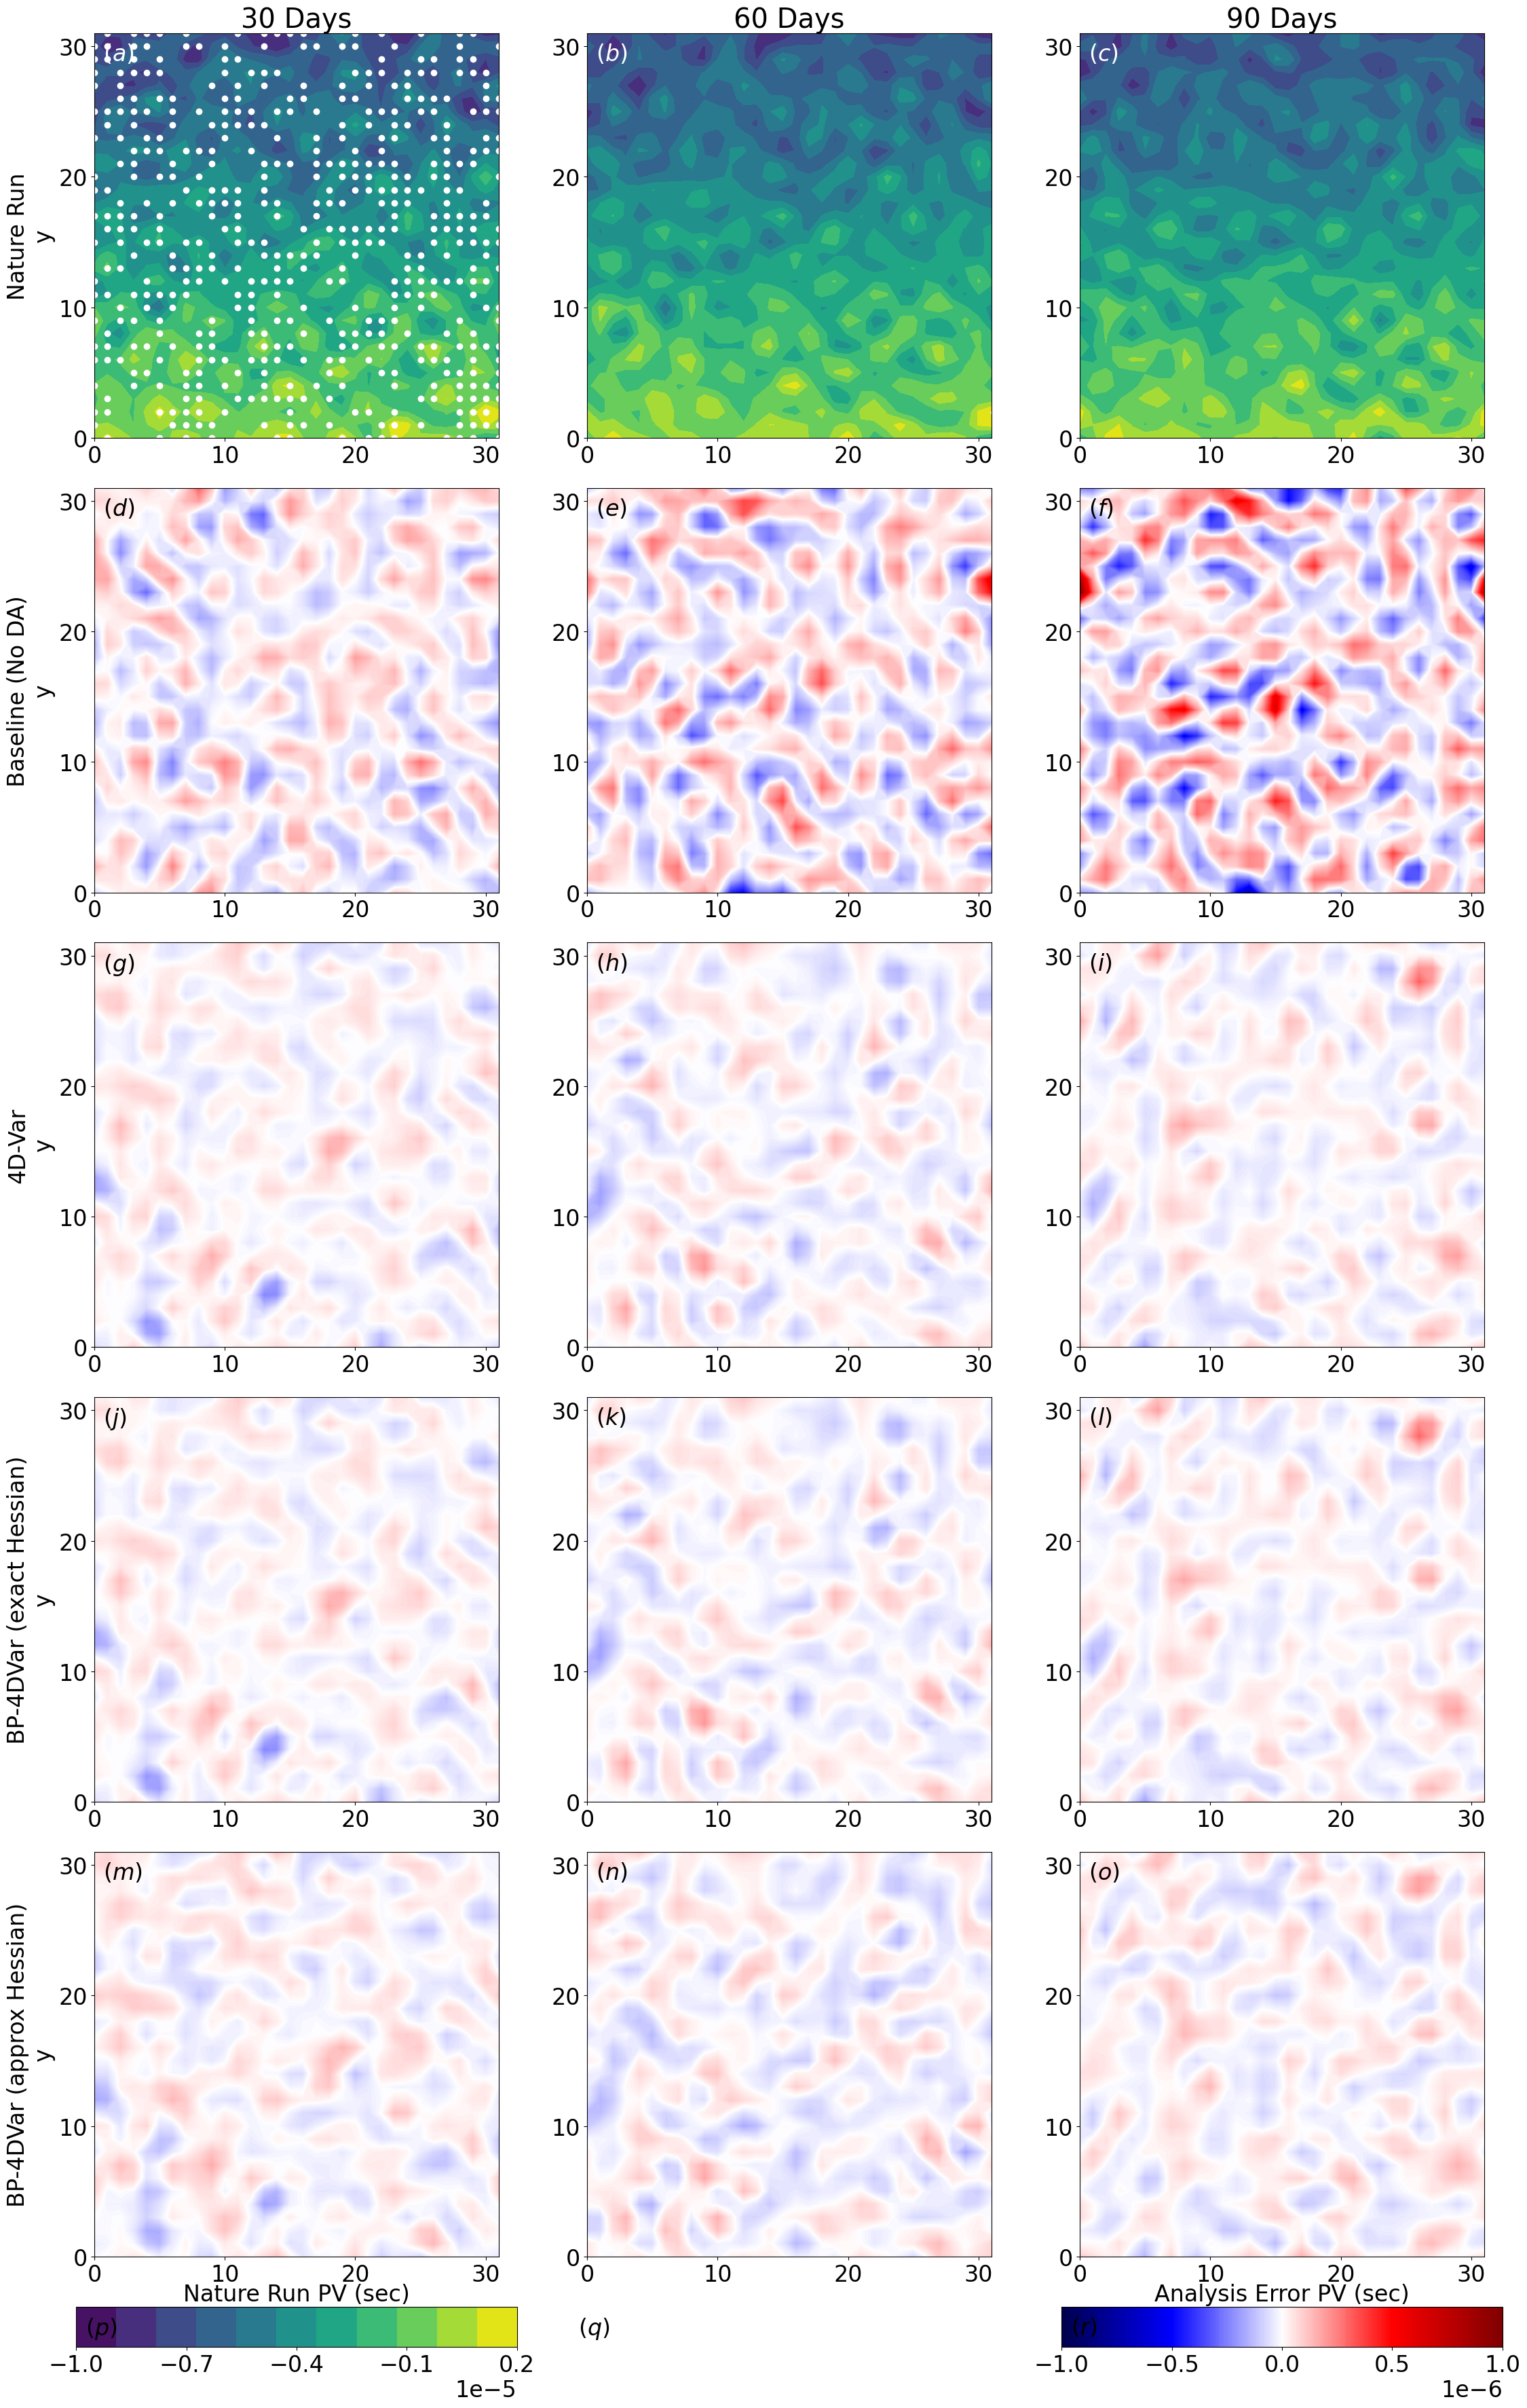

In [17]:
plt.rcParams.update({'font.size': 24})
time_intervals = [359, 719, 1079]
time_intervals_names = ['30 Days', '60 Days', '90 Days']

axes_height_ratios = np.ones(6)
axes_height_ratios[5] = 0.1
fig, axs = plt.subplots(6, 3, figsize = (23, 36),
                       gridspec_kw={"height_ratios":axes_height_ratios})#, 'hspace':0.275, 'wspace':0.05})
for i in range(axs.shape[0]-1):

    if i ==0:
        cmap = 'viridis'
        v = np.linspace(-1e-5, 2e-6, 12, endpoint=True)
        vticks = np.linspace(-1e-5, 2e-6, 5, endpoint=True)
        for j in range(3):
            vals = (vec_list[0].values[time_intervals[j]].reshape(2, 32, 32)[1]
                + nature_run.m.model.Qy[1]*nature_run.m.model.y)
            level1_obs = obs_z == 1
            im1 = axs[i, j].contourf(vals, v, cmap=cmap)
            axs[i, j].yaxis.set_ticks(np.arange(0, 31, 10))
            if j==0:
                axs[i, j].scatter(obs_x[level1_obs], obs_y[level1_obs], color='white')
                fig.colorbar(im1, cax=axs[-1, 0], orientation="horizontal", boundaries=v, ticks=vticks)
            axs[i, j].set_aspect('equal')
            axs[i, j].set_title(time_intervals_names[j])
            
    else:
        v = np.linspace(-1e-6, 1e-6, 250, endpoint=True)
        vticks = np.linspace(-1e-6, 1e-6, 5, endpoint=True)
        cmap = 'seismic'
        for j in range(3):
            da_vals = (vec_list[i].values[time_intervals[j]].reshape(2, 32, 32)[1]
                + nature_run.m.model.Qy[1]*nature_run.m.model.y)
            nr_vals =  (vec_list[0].values[time_intervals[j]].reshape(2, 32, 32)[1]
                + nature_run.m.model.Qy[1]*nature_run.m.model.y)
            vals = da_vals - nr_vals
            if i == 1 and j == 2:
                im2 = axs[i, j].contourf(vals,
                                         v,
                                         cmap=cmap)
                fig.colorbar(im2, cax=axs[-1, 2], orientation="horizontal",
                            boundaries=v, ticks=vticks)
            else:
                axs[i, j].contourf(vals, v, cmap=cmap)
            axs[i, j].set_aspect('equal')

            
            # Set labels nad ticks
            axs[i, j].yaxis.set_ticks(np.arange(0, 31, 10))
            if i==axs.shape[0]:
                axs[i, j].set_xlabel('x')                
    axs[i, 0].set_ylabel(names_list[i] + '\ny')


axs[-1,1].xaxis.set_visible(False)
axs[-1,1].yaxis.set_visible(False)

axs[-1,0].set_title('Nature Run PV (sec)', {'fontsize':24})

axs[-1,2].set_title('Analysis Error PV (sec)', {'fontsize':24})

for i, ax in enumerate(axs.flatten()):
    if i < 3:
        label_color='white'
    else:
        label_color='black'

    ax.annotate(
        label_list[i],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.4, -0.4), textcoords='offset fontsize',
        fontsize=24, verticalalignment='top', fontfamily='serif',
        color=label_color)

for spine in ['top', 'right', 'left', 'bottom']:
    axs[-1, 1].spines[spine].set_visible(False)
fig.tight_layout(h_pad=-0.1)
plt.show()

### Compare based on diff with 4dvar

In [18]:
vec_list = [nr_traj, baserun_traj, var4d_3outer_traj, bp_exact_3iter, bp_approx_3iter]
names_list = [
    'Nature Run',
    'Baseline (No DA)',
    '4D-Var',
    'BP-4DVar (exact Hessian) \n Compared to 4D-Var',
    'BP-4DVar (approx Hessian) \n Compared to 4D-Var'
    ]

##### Difference of abs error, level 1

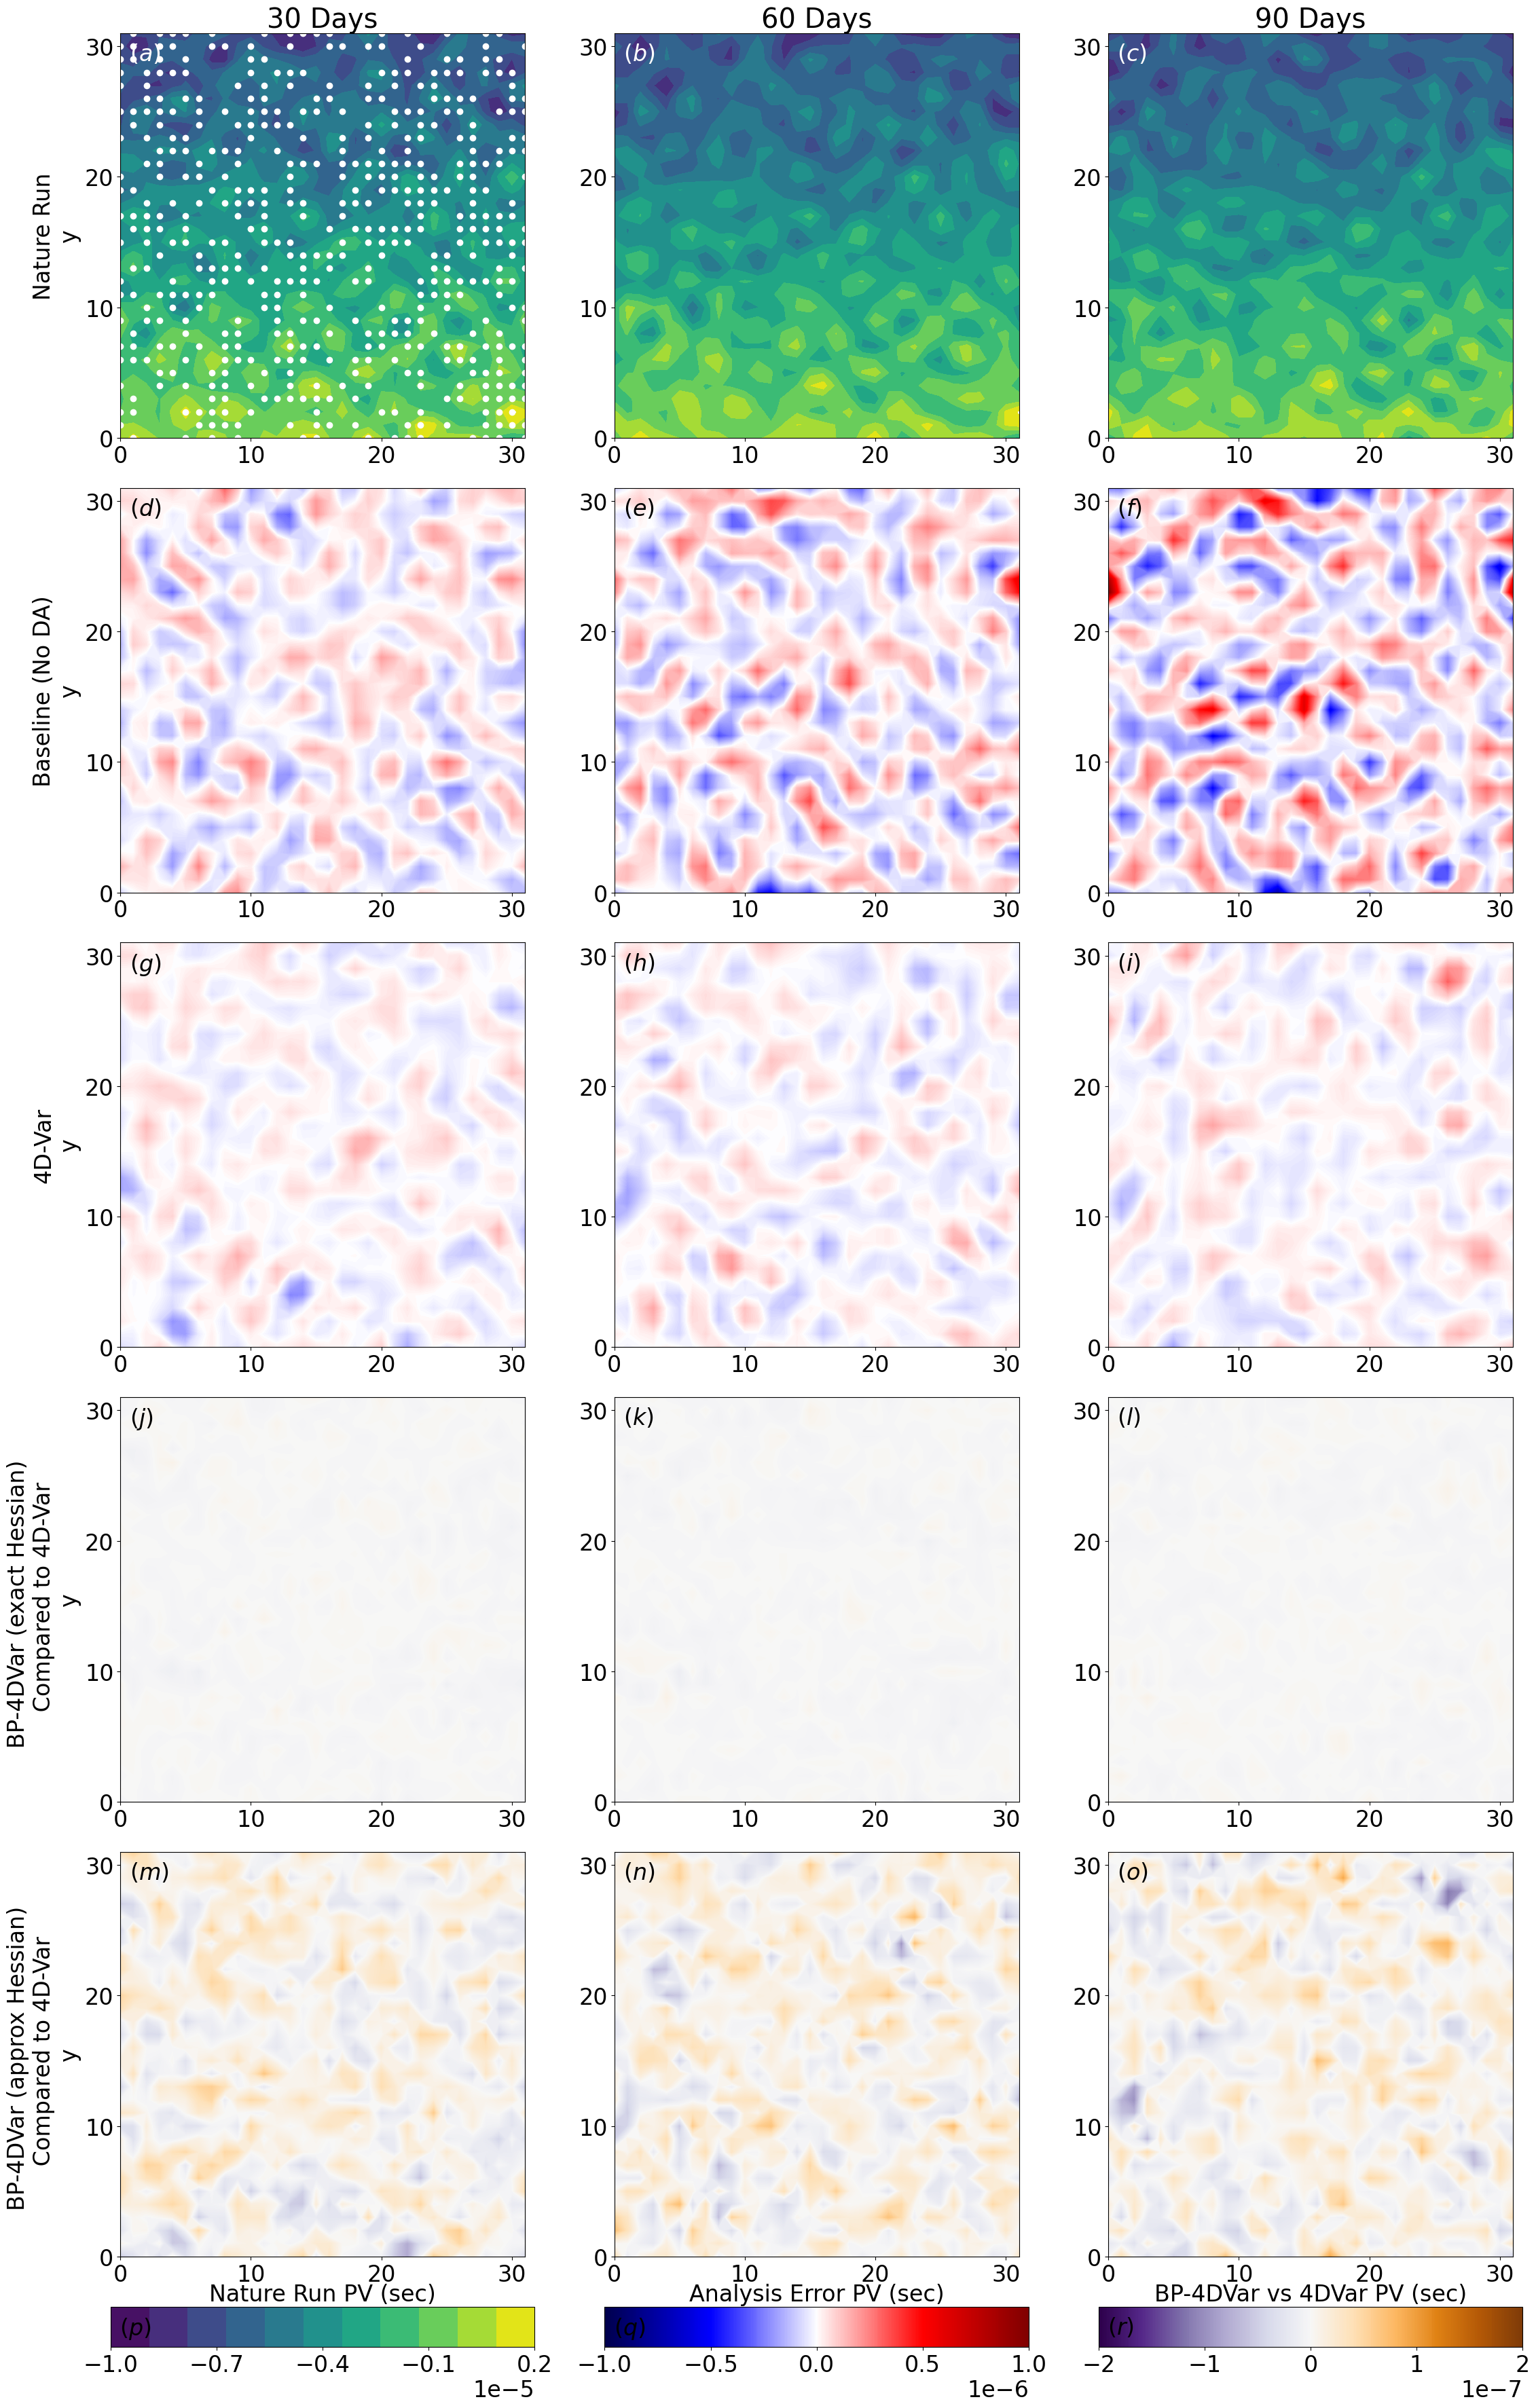

In [19]:
plt.rcParams.update({'font.size': 24})
time_intervals = [359, 719, 1079]
time_intervals_names = ['30 Days', '60 Days', '90 Days']

axes_height_ratios = np.ones(6)
axes_height_ratios[5] = 0.1
fig, axs = plt.subplots(6, 3, figsize = (23, 36),
                       gridspec_kw={"height_ratios":axes_height_ratios})#, 'hspace':0.275, 'wspace':0.05})
for i in range(axs.shape[0]-1):
    # Nature run
    if i ==0:
        cmap = 'viridis'
        v = np.linspace(-1e-5, 2e-6, 12, endpoint=True)
        vticks = np.linspace(-1e-5, 2e-6, 5, endpoint=True)
        for j in range(3):
            vals = (vec_list[0].values[time_intervals[j]].reshape(2, 32, 32)[1]
                + nature_run.m.model.Qy[1]*nature_run.m.model.y)
            level1_obs = obs_z == 1
            im1 = axs[i, j].contourf(vals, v, cmap=cmap)
            axs[i, j].yaxis.set_ticks(np.arange(0, 31, 10))
            if j==0:
                axs[i, j].scatter(obs_x[level1_obs], obs_y[level1_obs], color='white')
                fig.colorbar(im1, cax=axs[-1, 0], orientation="horizontal", boundaries=v, ticks=vticks)
            axs[i, j].set_aspect('equal')
            axs[i, j].set_title(time_intervals_names[j])    
    # Nature
    elif i < 3:
        v = np.linspace(-1e-6, 1e-6, 250, endpoint=True)
        vticks = np.linspace(-1e-6, 1e-6, 5, endpoint=True)
        cmap = 'seismic'
        for j in range(3):
            da_vals = (vec_list[i].values[time_intervals[j]].reshape(2, 32, 32)[1]
                + nature_run.m.model.Qy[1]*nature_run.m.model.y)
            nr_vals =  (vec_list[0].values[time_intervals[j]].reshape(2, 32, 32)[1]
                + nature_run.m.model.Qy[1]*nature_run.m.model.y)
            vals = da_vals - nr_vals
            if i == 1 and j == 2:
                im2 = axs[i, j].contourf(vals,
                                         v,
                                         cmap=cmap)
                fig.colorbar(im2, cax=axs[-1, 1], orientation="horizontal",
                            boundaries=v, ticks=vticks)
            else:
                axs[i, j].contourf(vals, v, cmap=cmap)
            axs[i, j].set_aspect('equal')

            
            # Set labels nad ticks
            axs[i, j].yaxis.set_ticks(np.arange(0, 31, 10))
            if i==axs.shape[0]:
                axs[i, j].set_xlabel('x') 
    else:
        cmap = 'PuOr_r'
        v = np.linspace(-2e-7, 2e-7, 250, endpoint=True)
        vticks = np.linspace(-2e-7, 2e-7, 5, endpoint=True)
        for j in range(3):
            da_vals = (vec_list[i].values[time_intervals[j]].reshape(2, 32, 32)[1]
                + nature_run.m.model.Qy[1]*nature_run.m.model.y)
            baseline_vals = (vec_list[2].values[time_intervals[j]].reshape(2, 32, 32)[1]
                + nature_run.m.model.Qy[1]*nature_run.m.model.y)
            nr_vals = (vec_list[0].values[time_intervals[j]].reshape(2, 32, 32)[1]
                + nature_run.m.model.Qy[1]*nature_run.m.model.y)
            baseline_diff = baseline_vals - nr_vals
            da_diff = da_vals - nr_vals

            vals = np.abs(da_diff) - np.abs(baseline_diff)

            axs[i, j].contourf(vals, v, cmap=cmap)
            if i == 3 and j == 2:
                im3 = axs[i, j].contourf(vals,
                                         v,
                                         cmap=cmap)
                fig.colorbar(im3, cax=axs[-1, 2], orientation="horizontal",
                            boundaries=v, ticks=vticks)

            axs[i, j].set_aspect('equal')

            # Set labels and ticks
            axs[i, j].yaxis.set_ticks(np.arange(0, 31, 10))
            if i==axs.shape[0]:
                axs[i, j].set_xlabel('x')

                
    axs[i, 0].set_ylabel(names_list[i] + '\ny')

axs[-1,0].set_title('Nature Run PV (sec)', {'fontsize':24})
axs[-1,1].set_title('Analysis Error PV (sec)', {'fontsize':24})
axs[-1,2].set_title('BP-4DVar vs 4DVar PV (sec)', {'fontsize':24})

for i, ax in enumerate(axs.flatten()):
    if i < 3:
        label_color='white'
    else:
        label_color='black'

    ax.annotate(
        label_list[i],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.4, -0.4), textcoords='offset fontsize',
        fontsize=24, verticalalignment='top', fontfamily='serif',
        color=label_color)

fig.tight_layout(h_pad=-0.1)
plt.show()

##### Difference of abs error, level 0

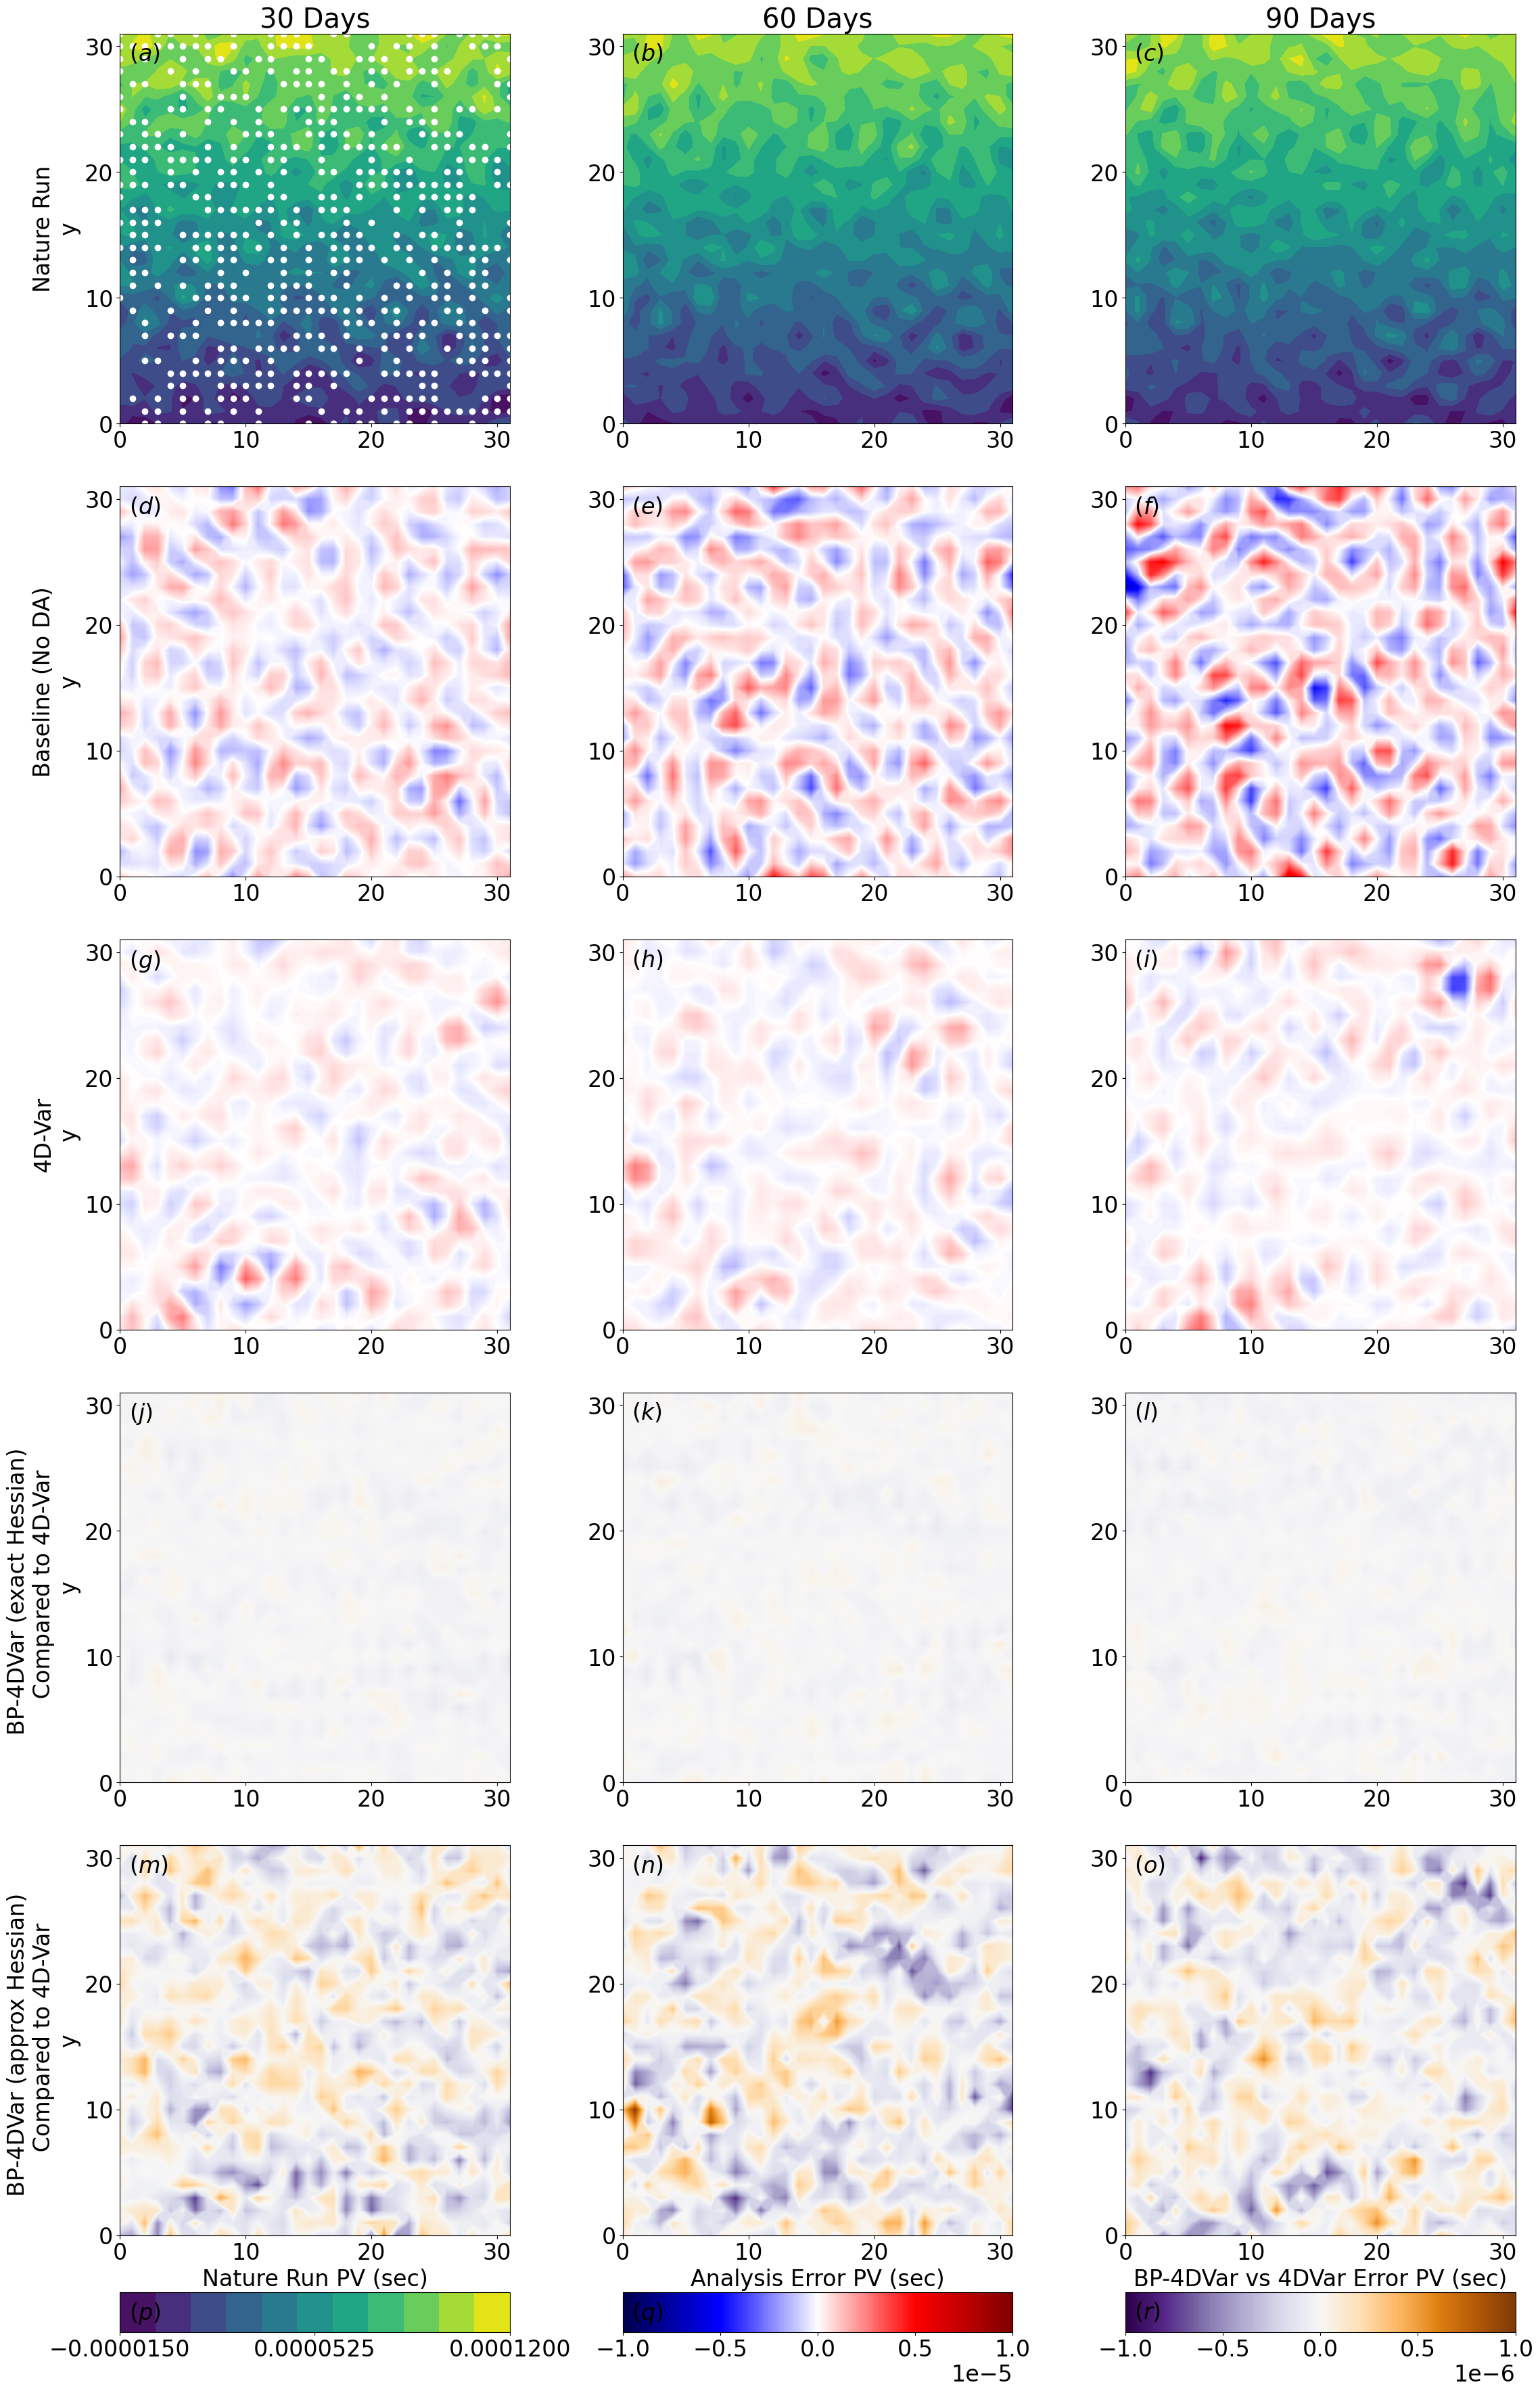

In [20]:
plt.rcParams.update({'font.size': 24})
time_intervals = [359, 719, 1079]
time_intervals_names = ['30 Days', '60 Days', '90 Days']
level=0
axes_height_ratios = np.ones(6)
axes_height_ratios[5] = 0.1
fig, axs = plt.subplots(6, 3, figsize = (23, 36),
                       gridspec_kw={"height_ratios":axes_height_ratios})#, 'hspace':0.275, 'wspace':0.05})
for i in range(axs.shape[0]-1):
    # Nature run
    if i ==0:
        cmap = 'viridis'
        v = np.linspace(-1.5e-5, 1.2e-4, 12, endpoint=True)
        vticks = np.linspace(-1.5e-5, 1.2e-4, 3, endpoint=True)
        for j in range(3):
            vals = (vec_list[0].values[time_intervals[j]].reshape(2, 32, 32)[level]
                + nature_run.m.model.Qy[level]*nature_run.m.model.y)
            level_obs = obs_z == level
            im1 = axs[i, j].contourf(vals, v, cmap=cmap)
            axs[i, j].yaxis.set_ticks(np.arange(0, 31, 10))
            if j==0:
                axs[i, j].scatter(obs_x[level_obs], obs_y[level_obs], color='white')
                fig.colorbar(im1, cax=axs[-1, 0], orientation="horizontal", boundaries=v, ticks=vticks)
            axs[i, j].set_aspect('equal')
            axs[i, j].set_title(time_intervals_names[j])    
    # Nature
    elif i < 3:
        v = np.linspace(-1e-5, 1e-5, 250, endpoint=True)
        vticks = np.linspace(-1e-5, 1e-5, 5, endpoint=True)
        cmap = 'seismic'
        for j in range(3):
            da_vals = (vec_list[i].values[time_intervals[j]].reshape(2, 32, 32)[level]
                + nature_run.m.model.Qy[level]*nature_run.m.model.y)
            nr_vals =  (vec_list[0].values[time_intervals[j]].reshape(2, 32, 32)[level]
                + nature_run.m.model.Qy[level]*nature_run.m.model.y)
            vals = da_vals - nr_vals
            if i == 1 and j == 2:
                im2 = axs[i, j].contourf(vals,
                                         v,
                                         cmap=cmap)
                fig.colorbar(im2, cax=axs[-1, 1], orientation="horizontal",
                            boundaries=v, ticks=vticks)
            else:
                axs[i, j].contourf(vals, v, cmap=cmap)
            axs[i, j].set_aspect('equal')

            
            # Set labels nad ticks
            axs[i, j].yaxis.set_ticks(np.arange(0, 31, 10))
            if i==axs.shape[0]:
                axs[i, j].set_xlabel('x') 
    else:
        cmap = 'PuOr_r'
        v = np.linspace(-1e-6, 1e-6, 250, endpoint=True)
        vticks = np.linspace(-1e-6, 1e-6, 5, endpoint=True)
        for j in range(3):
            da_vals = (vec_list[i].values[time_intervals[j]].reshape(2, 32, 32)[level]
                + nature_run.m.model.Qy[level]*nature_run.m.model.y)
            baseline_vals = (vec_list[2].values[time_intervals[j]].reshape(2, 32, 32)[level]
                + nature_run.m.model.Qy[level]*nature_run.m.model.y)
            nr_vals = (vec_list[0].values[time_intervals[j]].reshape(2, 32, 32)[level]
                + nature_run.m.model.Qy[level]*nature_run.m.model.y)
            baseline_diff = baseline_vals - nr_vals
            da_diff = da_vals - nr_vals

            vals = np.abs(da_diff) - np.abs(baseline_diff)

            axs[i, j].contourf(vals, v, cmap=cmap)
            if i == 3 and j == 2:
                im3 = axs[i, j].contourf(vals,
                                         v,
                                         cmap=cmap)
                fig.colorbar(im3, cax=axs[-1, 2], orientation="horizontal",
                            boundaries=v, ticks=vticks)

            axs[i, j].set_aspect('equal')

            # Set labels and ticks
            axs[i, j].yaxis.set_ticks(np.arange(0, 31, 10))
            if i==axs.shape[0]:
                axs[i, j].set_xlabel('x')

                
    axs[i, 0].set_ylabel(names_list[i] + '\ny')

axs[-1,0].set_title('Nature Run PV (sec)', {'fontsize':24})
axs[-1,1].set_title('Analysis Error PV (sec)', {'fontsize':24})
axs[-1,2].set_title('BP-4DVar vs 4DVar Error PV (sec)', {'fontsize':24})

for i, ax in enumerate(axs.flatten()):
    label_color='black'

    ax.annotate(
        label_list[i],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.4, -0.4), textcoords='offset fontsize',
        fontsize=24, verticalalignment='top', fontfamily='serif',
        color=label_color)
    
fig.tight_layout(h_pad=-0.1)
plt.show()

# Visualize a larger system

In [21]:
system_dim_xy = 64
nr_steps = spinup_size + valid_size + transient_size + test_size
delta_t=7200
random_seed=system_dim_xy

In [22]:
nature_run = dab.data.PyQGJax(nx=system_dim_xy, ny=system_dim_xy, delta_t=delta_t, store_as_jax=True, random_seed=random_seed)

nature_run.generate(n_steps=nr_steps) 
nr_spinup, nr_valid, nr_transient_and_test = nature_run.split_train_valid_test(
    spinup_size, valid_size, transient_size + test_size)
nr_transient, nr_test, _ = nr_transient_and_test.split_train_valid_test(transient_size, test_size, 0)

2024-08-01 11:37:40.476561: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:37:40.500125: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:37:40.525518: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


Initial condition not set. Start with random IC.


2024-08-01 11:37:40.914959: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:37:41.165804: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:37:41.189236: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:37:41.507218: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:37:41.528817: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:37:41.529604: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:38:18.564569: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-08-01 11:38:23.145413: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


In [23]:
### Observations
obs_location_count = round(nature_run.system_dim/2)

# First we need to calculate the per-variable SD for QGS model
per_variable_sd = np.std(nr_spinup.values, axis=0)
obs_sd = 0.1*per_variable_sd

obs_pyqg = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, nr_test.time_dim, 3), # Observation every other timestep
    random_location_count = obs_location_count, # Probability of picking each location in l63.system_dim for random sampling
    error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
    error_sd = obs_sd, # Standard deviation for observation error, Gaussian/Normal distribution
    random_seed=system_dim_xy+1, # We can specify a random seed. Default is 99
    stationary_observers=True,
    store_as_jax=True
)

obs_vec_pyqg = obs_pyqg.observe()

2024-08-01 11:38:33.797506: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


In [24]:
# Convert obs location indices to gridded locations
obs_z = np.floor_divide(obs_vec_pyqg.location_indices[0], 64**2)
obs_x = np.floor_divide(np.remainder(obs_vec_pyqg.location_indices[0], 64**2), 64)
obs_y =  np.remainder(np.remainder(obs_vec_pyqg.location_indices[0], 64**2), 64)

In [25]:
def load_pickle(pkl_path):
    with open(pkl_path, 'rb') as f:
        state_vec = pickle.load(f)
    return state_vec


In [26]:
nr_traj = dab.vector.StateVector(values=nr_test.values, times=nr_test.times)
baserun_traj = load_pickle('./out/pyqg_jax/pyqg_baserun_results_sysdimxy_64_v1.pkl')
bp_approx_3iter = load_pickle('./out/pyqg_jax/pyqg_bp_results_sysdimxy_64_3epoch_hessian_approx_v8.pkl')


In [27]:
vec_list = [nr_traj, baserun_traj, bp_approx_3iter]
names_list = [
    'Nature Run',
    'Baseline (No DA)',
    'BP-4DVar (approx Hessian)'
    ]

In [28]:
# Total RMSE for backprop
np.sqrt(np.mean(np.square(bp_approx_3iter.values[:1080] - nr_traj.values[:1080])))

3.4278877215861667e-07

In [29]:
# Total RMSE for base run (no DA)
np.sqrt(np.mean(np.square(baserun_traj.values[:1080] - nr_traj.values[:1080])))

1.8160861150361389e-06

0 2.7966564107721653e-06 -8.999563522830478e-06
1 4.185228137100443e-06 -3.2318835739259937e-06
2 2.5211899847943693e-07 -2.78110063480189e-07


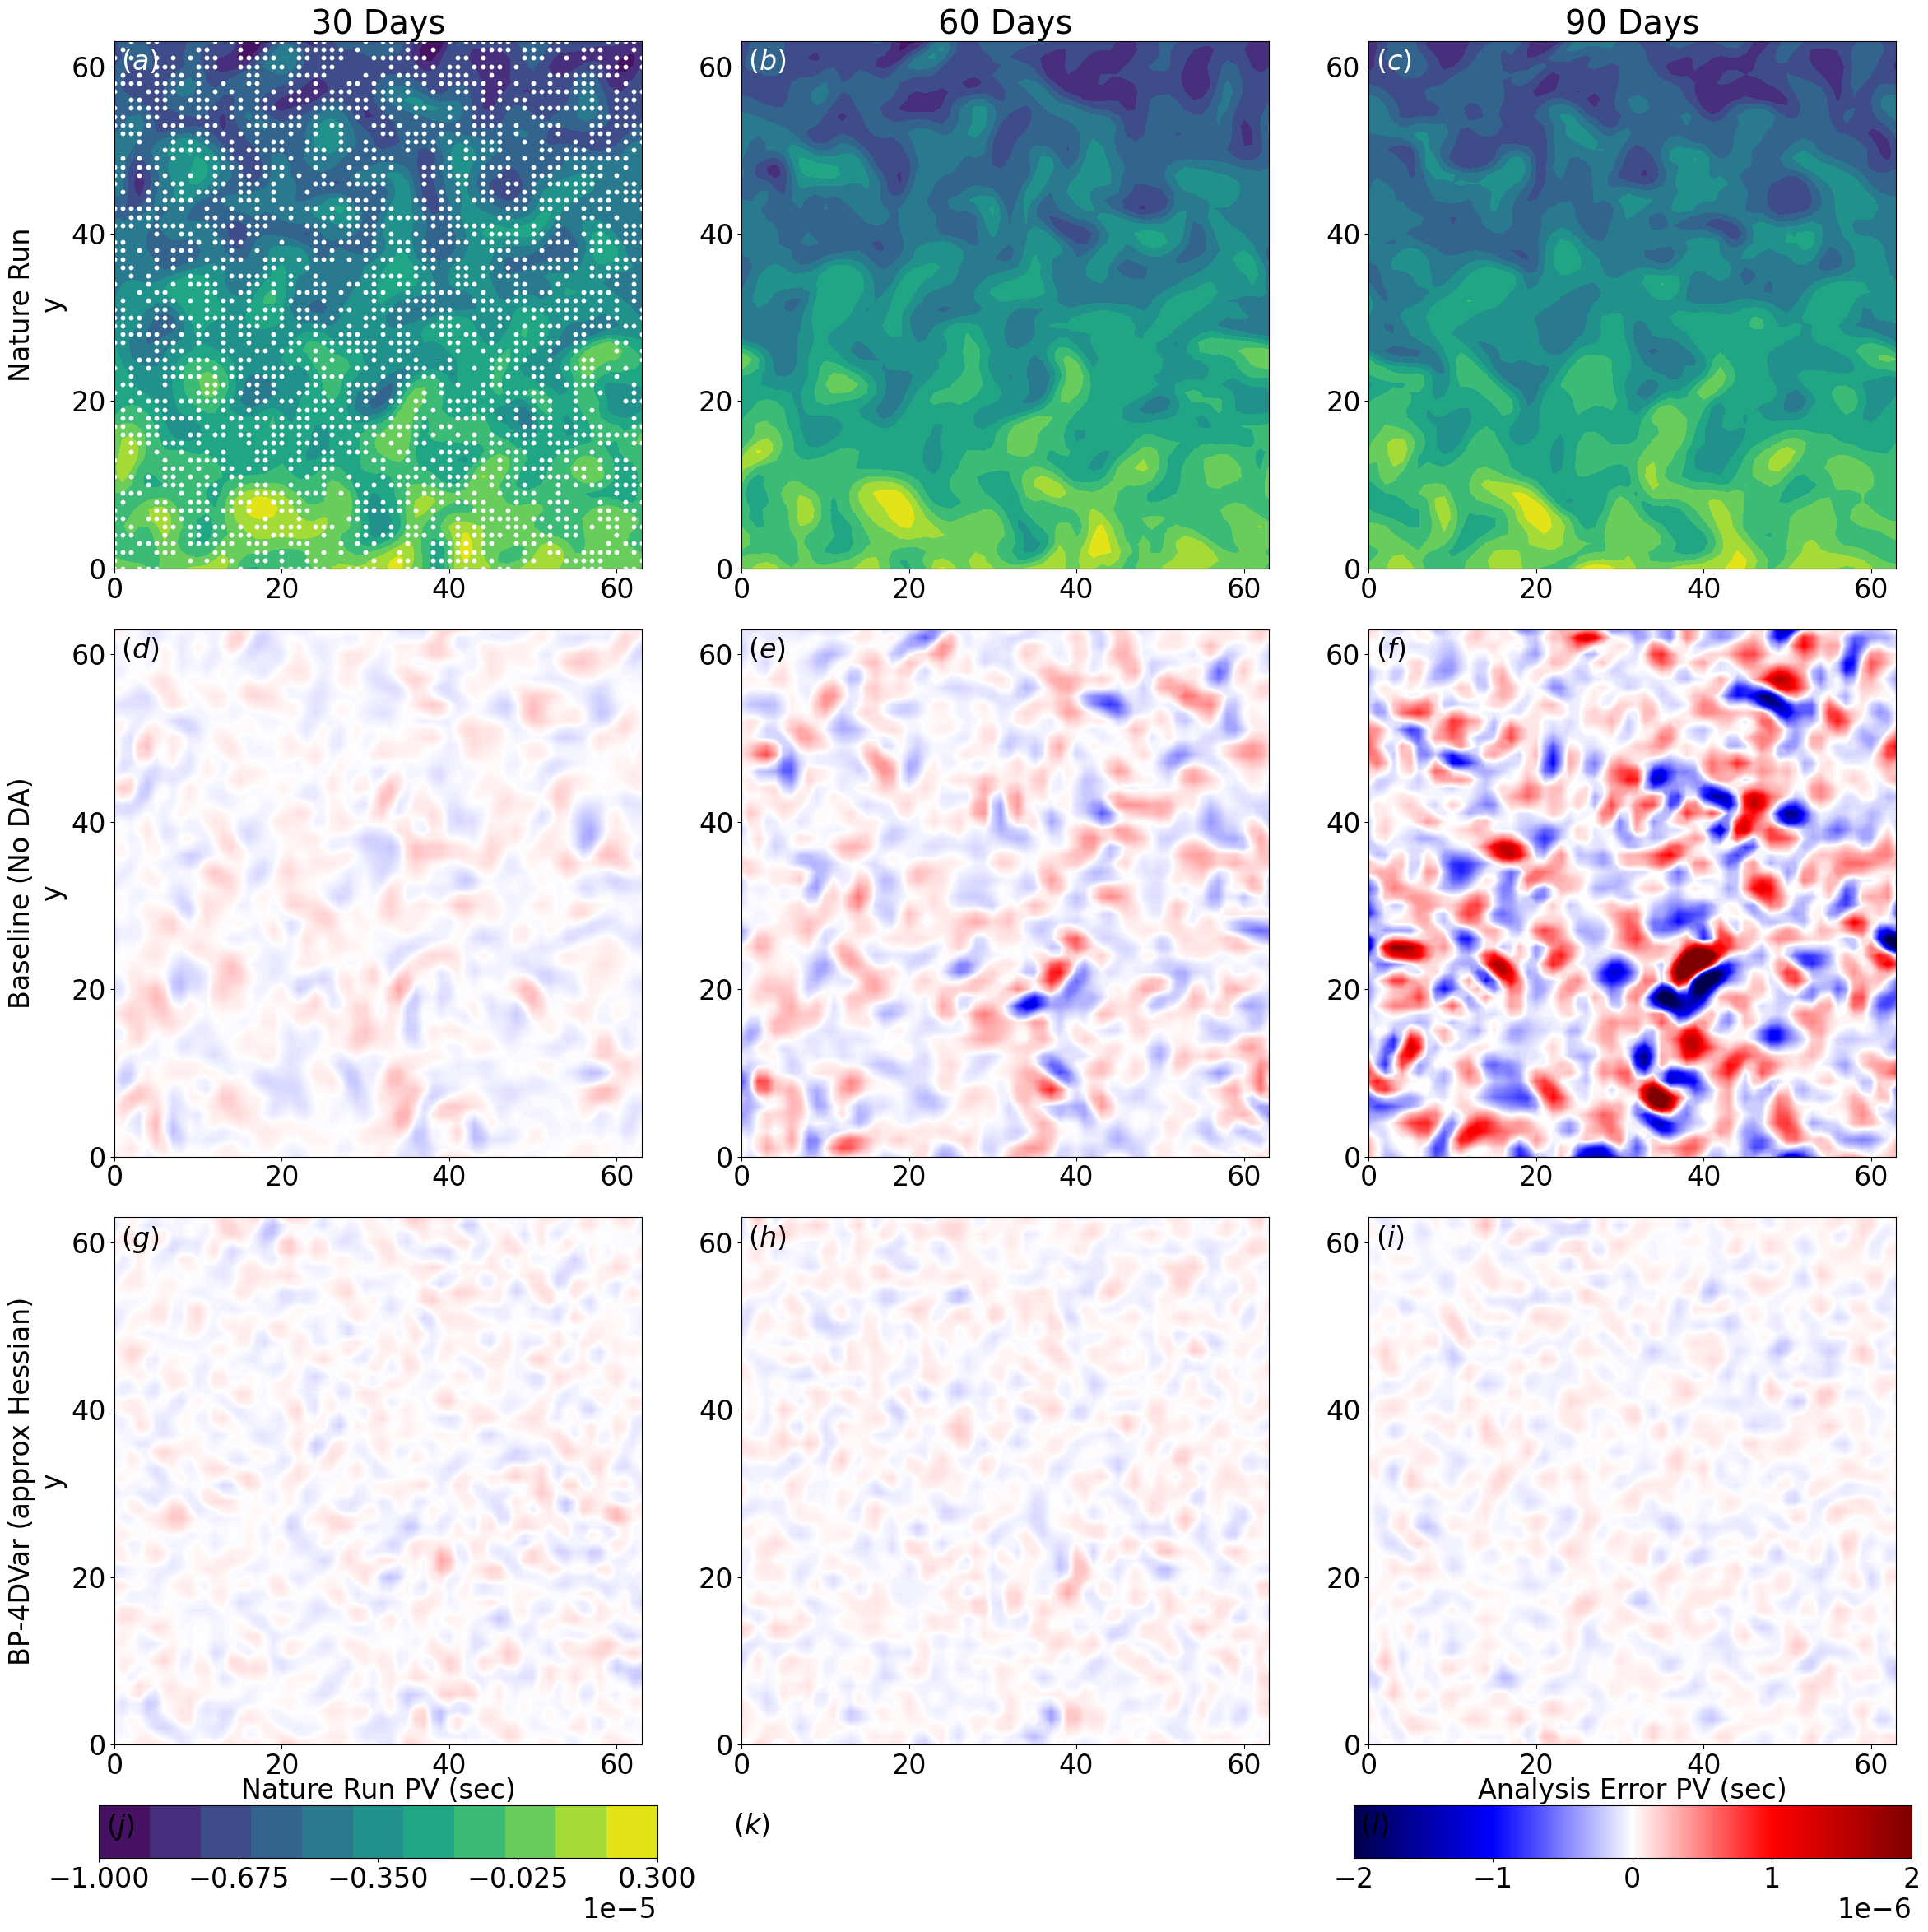

In [30]:
plt.rcParams.update({'font.size': 24})
time_intervals = [359, 719, 1079]
time_intervals_names = ['30 Days', '60 Days', '90 Days']
num_plots = 4
axes_height_ratios = np.ones(num_plots)
axes_height_ratios[-1] = 0.1
level=1
fig, axs = plt.subplots(num_plots, 3, figsize = (24, 24),
                       gridspec_kw={"height_ratios":axes_height_ratios})#, 'hspace':0.275, 'wspace':0.05})
for i in range(axs.shape[0]-1):

    if i ==0:
        cmap = 'viridis'
        v = np.linspace(-1e-5, 3e-6, 12, endpoint=True)
        vticks = np.linspace(-1e-5, 3e-6, 5, endpoint=True)
        for j in range(3):
            vals = (vec_list[0].values[time_intervals[j]].reshape(2, system_dim_xy, system_dim_xy)[level]
                + nature_run.m.model.Qy[level]*nature_run.m.model.y)
            level1_obs = obs_z == 1
            im1 = axs[i, j].contourf(vals, v, cmap=cmap)
            axs[i, j].yaxis.set_ticks(np.arange(0, system_dim_xy-1, 20))
            if j==0:
                axs[i, j].scatter(obs_x[level1_obs], obs_y[level1_obs], color='white', s=10)
                fig.colorbar(im1, cax=axs[-1, 0], orientation="horizontal", boundaries=v, ticks=vticks)
            axs[i, j].set_aspect('equal')
            axs[i, j].set_title(time_intervals_names[j])
            
    else:
        v = np.linspace(-2e-6, 2e-6, 250, endpoint=True)
        vticks = np.linspace(-2e-6, 2e-6, 5, endpoint=True)
        cmap = 'seismic'
        for j in range(3):
            da_vals = (vec_list[i].values[time_intervals[j]].reshape(2, system_dim_xy, system_dim_xy)[level]
                + nature_run.m.model.Qy[level]*nature_run.m.model.y)
            nr_vals =  (vec_list[0].values[time_intervals[j]].reshape(2, system_dim_xy, system_dim_xy)[level]
                + nature_run.m.model.Qy[level]*nature_run.m.model.y)
            vals = da_vals - nr_vals
            if i == 1 and j == 2:
                im2 = axs[i, j].contourf(vals,
                                         v,
                                         cmap=cmap)
                axs[i, j].contourf(vals,
                         vmin=-2e-6, vmax=2e-6, levels=250,
                         cmap=cmap)
                fig.colorbar(im2, cax=axs[-1, 2], orientation="horizontal",
                            boundaries=v, ticks=vticks)
            else:
                axs[i, j].contourf(vals, v, cmap=cmap)
            axs[i, j].set_aspect('equal')

            
            # Set labels nad ticks
            axs[i, j].yaxis.set_ticks(np.arange(0, system_dim_xy-1, 20))
            if i==axs.shape[0]:
                axs[i, j].set_xlabel('x')                
    axs[i, 0].set_ylabel(names_list[i] + '\ny')
    print(i, np.max(vals), np.min(vals))

axs[-1,1].xaxis.set_visible(False)
axs[-1,1].yaxis.set_visible(False)

axs[-1,0].set_title('Nature Run PV (sec)', {'fontsize':24})

axs[-1,2].set_title('Analysis Error PV (sec)', {'fontsize':24})

for i, ax in enumerate(axs.flatten()):
    if i < 3:
        label_color='white'
    else:
        label_color='black'

    ax.annotate(
        label_list[i],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.25, -0.25), textcoords='offset fontsize',
        fontsize=24, verticalalignment='top', fontfamily='serif',
        color=label_color)

for spine in ['top', 'right', 'left', 'bottom']:
    axs[-1, 1].spines[spine].set_visible(False)
fig.tight_layout(h_pad=-0.1)
plt.show()